In [1]:
import pandas as pd
import lightgbm as lgb
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
path='./data'
test = pd.read_csv(path + '/Metro_testB/testB_submit_2019-01-27.csv')
test_26 = pd.read_csv(path + '/Metro_testB/testB_record_2019-01-26.csv')

In [8]:
# 时间处理
def process_time(df_):

    df= df_.copy()
    # base time
    df['day'] = df['time'].apply(lambda x: int(x[8:10]))
    df['week'] = pd.to_datetime(df['time']).dt.dayofweek + 1
    df['weekend'] = (pd.to_datetime(df.time).dt.weekday >= 5).astype(int)
    df['hour'] = df['time'].apply(lambda x: int(x[11:13]))
    df['minute'] = df['time'].apply(lambda x: int(x[14:15] + '0'))
    del df['time']
    return df

In [9]:
data = process_time(test_26)

In [10]:
# 构造基本特征
def get_base_features(df):
    
    # count,sum
    result = df.groupby(['stationID','week', 'lineID','weekend', 'day', 'hour', 'minute']).status.agg(
        ['count', 'sum']).reset_index()
    
    # 各个站每10分钟一段的流量情况
    result['inNums'] = result['sum']
    result['outNums'] = result['count'] - result['sum']
    del result['sum'], result['count']
    return result

In [11]:
data= get_base_features(data)
data.head(10)

,stationID,week,lineID,weekend,day,hour,minute,inNums,outNums
0,0,6,B,1,26,0,0,0,1
1,0,6,B,1,26,0,10,0,3
2,0,6,B,1,26,0,20,0,2
3,0,6,B,1,26,5,30,13,0
4,0,6,B,1,26,5,40,33,0
5,0,6,B,1,26,5,50,31,2
6,0,6,B,1,26,6,0,49,1
7,0,6,B,1,26,6,10,53,0
8,0,6,B,1,26,6,20,51,1
9,0,6,B,1,26,6,30,88,54


In [12]:
#加载所有文件数据

data_list = os.listdir(path+'/Metro_train/')
for i in range(0, len(data_list)):
    if data_list[i].split('.')[-1] == 'csv':
        print('已加载',data_list[i], i)
        df = pd.read_csv(path+'/Metro_train/' + data_list[i])
        df = process_time(df)
        df = get_base_features(df)
        data = pd.concat([data, df], axis=0, ignore_index=True)
    else:
        continue

已加载 record_2019-01-01.csv 0
已加载 record_2019-01-02.csv 1
已加载 record_2019-01-03.csv 2
已加载 record_2019-01-04.csv 3
已加载 record_2019-01-05.csv 4
已加载 record_2019-01-06.csv 5
已加载 record_2019-01-07.csv 6
已加载 record_2019-01-08.csv 7
已加载 record_2019-01-09.csv 8
已加载 record_2019-01-10.csv 9
已加载 record_2019-01-11.csv 10
已加载 record_2019-01-12.csv 11
已加载 record_2019-01-13.csv 12
已加载 record_2019-01-14.csv 13
已加载 record_2019-01-15.csv 14
已加载 record_2019-01-16.csv 15
已加载 record_2019-01-17.csv 16
已加载 record_2019-01-18.csv 17
已加载 record_2019-01-19.csv 18
已加载 record_2019-01-20.csv 19
已加载 record_2019-01-21.csv 20
已加载 record_2019-01-22.csv 21
已加载 record_2019-01-23.csv 22
已加载 record_2019-01-24.csv 23
已加载 record_2019-01-25.csv 24


In [24]:
# 构建测试集

test['week'] = pd.to_datetime(test['startTime']).dt.dayofweek + 1
test['weekend'] = (pd.to_datetime(test.startTime).dt.weekday >= 5).astype(int)
test['day'] = test['startTime'].apply(lambda x: int(x[8:10]))
test['hour'] = test['startTime'].apply(lambda x: int(x[11:13]))
test['minute'] = test['startTime'].apply(lambda x: int(x[14:15] + '0'))
test = test.drop(['startTime', 'endTime'], axis=1)

In [25]:
test['lineID']=test['stationID'].map(dict(zip(test_26.stationID,test_26.lineID)))

In [36]:
test.tail()

,stationID,inNums,outNums,week,weekend,day,hour,minute,lineID
11659,80,NaN,NaN,7,1,27,23,10,A
11660,80,NaN,NaN,7,1,27,23,20,A
11661,80,NaN,NaN,7,1,27,23,30,A
11662,80,NaN,NaN,7,1,27,23,40,A
11663,80,NaN,NaN,7,1,27,23,50,A


In [16]:
data = pd.concat([data, test], axis=0, ignore_index=True)

In [35]:
data.head()

,day,hour,inNums,lineID,minute,outNums,stationID,week,weekend
0,26,0,0.0,B,0,1.0,0,6,1
1,26,0,0.0,B,10,3.0,0,6,1
2,26,0,0.0,B,20,2.0,0,6,1
3,26,5,13.0,B,30,0.0,0,6,1
4,26,5,33.0,B,40,0.0,0,6,1


In [205]:
data_3=data_2.copy()

In [206]:
data=data_3

In [207]:
data.day.unique()

array([26,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 27], dtype=int64)

In [208]:
data.day.value_counts()

27    11664
23     9188
25     9181
26     9153
22     9153
24     9147
9      9086
17     9072
21     9069
5      9052
2      9046
10     9038
3      9028
15     9023
19     9017
11     9006
8      8989
20     8985
18     8984
16     8974
13     8973
12     8973
4      8968
7      8959
14     8946
1      8941
6      8925
Name: day, dtype: int64

In [209]:
data.isnull().sum()

day                  0
hour                 0
inNums           11664
lineID             144
minute               0
outNums          11664
stationID            0
week                 0
weekend              0
lineID_new         144
stationID_new        0
dtype: int64

In [210]:
# # # 构建lineID
lineID_new=data.groupby(['lineID']).inNums.mean().sort_values().index
data['lineID_new']=data['lineID'].map(dict(zip(lineID_new,range(3))))

In [211]:
# data.groupby(['lineID']).inNums.mean().sort_values().index

In [212]:
# data[data.stationID==15].head()

In [213]:
# stationID重新编码  按平均出入次数
def get_station_new(data):
    stationID_new=data.groupby(['stationID']).inNums.mean().sort_values().index
    data['stationID_new']=data['stationID'].map(dict(zip(stationID_new,range(81))))
    return data

data=get_station_new(data)

In [214]:
# 补充时段缺失值
def get_new_data(data,test,i):
    temp=test[['stationID','hour','minute']]
    temp2=data[data.day==i]
    temp=temp.merge(temp2,on=['stationID','hour','minute'],how='left')
    temp.fillna({'day':i,'week':temp2.week.unique()[0],'inNums':0,'outNums':0,'weekend':temp2.weekend.unique()[0],'lineID':temp2.lineID.unique()[0],'stationID':temp2.stationID.unique()[0],'lineID_new':temp2.lineID_new.unique()[0],'stationID_new':temp2.stationID_new.unique()[0]},inplace=True)
    return temp

In [215]:
data.day.unique()[:]

array([26,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 27], dtype=int64)

In [216]:
data_new=get_new_data(data,test,26)
for i in data.day.unique()[1:]:   
    temp_df=get_new_data(data,test,i)
    data_new = pd.concat([data_new, temp_df], axis=0, ignore_index=True)

In [217]:
data_new.isnull().sum()

stationID        0
hour             0
minute           0
day              0
inNums           0
lineID           0
outNums          0
week             0
weekend          0
lineID_new       0
stationID_new    0
dtype: int64

In [218]:
data_new.day.value_counts()

13.0    11664
23.0    11664
2.0     11664
17.0    11664
14.0    11664
9.0     11664
4.0     11664
19.0    11664
5.0     11664
8.0     11664
21.0    11664
11.0    11664
16.0    11664
3.0     11664
24.0    11664
18.0    11664
10.0    11664
25.0    11664
26.0    11664
20.0    11664
27.0    11664
6.0     11664
7.0     11664
22.0    11664
12.0    11664
15.0    11664
1.0     11664
Name: day, dtype: int64

In [219]:
data=data_new

In [220]:
data.day.unique()

array([26.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       27.])

In [221]:
#   短期特征 构建lagging特征  取前7天（时序数据）

# 提取前i天的记录作为特征
def get_lagging_day(d,i):

        return d + i

def create_lagging(df,df_original,day):
    

    stat_columns = ['inNums', 'outNums']
    # tmp用来构建时序特征
    tmp = df_original.copy()
    tmp['day'] = tmp['day'].apply(get_lagging_day,args = (day,))
    for i in range(len(stat_columns)):
        tmp.rename(columns={stat_columns[i]: stat_columns[i] + '_lagging'+str(day)}, inplace=True)
        stat_columns[i]+='_lagging'+str(day)
        
    stat_columns.extend(['stationID', 'day', 'hour', 'minute'])
    tmp = tmp[stat_columns]
    df = df.merge(tmp, on=['stationID', 'day', 'hour', 'minute'], how='left')
    return df
data_lagging = create_lagging(data,data, 1)
for i in range(2,8):
    data_lagging = create_lagging(data_lagging, data, i)

In [222]:
data_lagging.head()

,stationID,hour,minute,day,inNums,lineID,outNums,week,weekend,lineID_new,...,inNums_lagging3,outNums_lagging3,inNums_lagging4,outNums_lagging4,inNums_lagging5,outNums_lagging5,inNums_lagging6,outNums_lagging6,inNums_lagging7,outNums_lagging7
0,0,0,0,26.0,0.0,B,1.0,6.0,1.0,2.0,...,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,10,26.0,0.0,B,3.0,6.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,20,26.0,0.0,B,2.0,6.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,30,26.0,0.0,B,0.0,6.0,1.0,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,0,0,40,26.0,0.0,B,0.0,6.0,1.0,2.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [223]:
data_lagging.day.unique()

array([26.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       27.])

In [224]:
data_lagging.isnull().sum()

stationID               0
hour                    0
minute                  0
day                     0
inNums                  0
lineID                  0
outNums                 0
week                    0
weekend                 0
lineID_new              0
stationID_new           0
inNums_lagging1     11664
outNums_lagging1    11664
inNums_lagging2     23328
outNums_lagging2    23328
inNums_lagging3     34992
outNums_lagging3    34992
inNums_lagging4     46656
outNums_lagging4    46656
inNums_lagging5     58320
outNums_lagging5    58320
inNums_lagging6     69984
outNums_lagging6    69984
inNums_lagging7     81648
outNums_lagging7    81648
dtype: int64

In [225]:
data=data_lagging

In [226]:
# 选取9号后作为数据集
data=data[data.day>=9]

In [227]:
data.isnull().sum()

stationID           0
hour                0
minute              0
day                 0
inNums              0
lineID              0
outNums             0
week                0
weekend             0
lineID_new          0
stationID_new       0
inNums_lagging1     0
outNums_lagging1    0
inNums_lagging2     0
outNums_lagging2    0
inNums_lagging3     0
outNums_lagging3    0
inNums_lagging4     0
outNums_lagging4    0
inNums_lagging5     0
outNums_lagging5    0
inNums_lagging6     0
outNums_lagging6    0
inNums_lagging7     0
outNums_lagging7    0
dtype: int64

In [228]:
data.columns

Index(['stationID', 'hour', 'minute', 'day', 'inNums', 'lineID', 'outNums',
       'week', 'weekend', 'lineID_new', 'stationID_new', 'inNums_lagging1',
       'outNums_lagging1', 'inNums_lagging2', 'outNums_lagging2',
       'inNums_lagging3', 'outNums_lagging3', 'inNums_lagging4',
       'outNums_lagging4', 'inNums_lagging5', 'outNums_lagging5',
       'inNums_lagging6', 'outNums_lagging6', 'inNums_lagging7',
       'outNums_lagging7'],
      dtype='object')

In [229]:
data.day.unique()

array([26.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
       21., 22., 23., 24., 25., 27.])

In [230]:
# 添加lagging的统计特征

#3天内的统计值
def get_new_features(data):
    data['inNums_mean_3']=data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].mean(axis=1)
#     data['inNums_max_3']=data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].max(axis=1)
#     data['inNums_min_3']=data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].min(axis=1)
#     data['inNums_median_3']=data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].median(axis=1)
#     data['inNums_percenrt_1_3']=data['inNums_lagging1']/(data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].sum(axis=1)+1e-5)
#     data['inNums_percenrt_2_3']=data['inNums_lagging1']/(data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].sum(axis=1)+1e-5)
#     data['inNums_percenrt_3_3']=data['inNums_lagging1']/(data[['inNums_lagging1','inNums_lagging2','inNums_lagging3']].sum(axis=1)+1e-5)
    
    data['inNums_diff_1']=data['inNums_lagging1']-data['inNums_lagging2']
    data['inNums_diff_2']=data['inNums_lagging2']-data['inNums_lagging3']
    data['inNums_diff1_2']=data['inNums_diff_1']-data['inNums_diff_2']
    data['inNums_divide_1']=data['inNums_lagging1']/(data['inNums_lagging2']+1e-5)
    data['inNums_divide_2']=data['inNums_lagging2']/(data['inNums_lagging3']+1e-5)
    
    
    data['outNums_mean_3']=data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].mean(axis=1)
#     data['outNums_max_3']=data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].max(axis=1)
#     data['outNums_min_3']=data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].min(axis=1)
                                                   
    data['outNums_diff_1']=data['outNums_lagging1']-data['outNums_lagging2']
    data['outNums_diff_2']=data['outNums_lagging2']-data['outNums_lagging3']
    data['outNums_diff1_2']=data['outNums_diff_1']-data['outNums_diff_2']
    data['outNums_divide_1']=data['outNums_lagging1']/(data['outNums_lagging2']+1e-5)
    data['outNums_divide_2']=data['outNums_lagging2']/(data['outNums_lagging3']+1e-5)
#     data['outNums_percenrt_1_3']=data['outNums_lagging1']/(data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].sum(axis=1)+1e-5)
#     data['outNums_percenrt_2_3']=data['outNums_lagging2']/(data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].sum(axis=1)+1e-5)
#     data['outNums_percenrt_3_3']=data['outNums_lagging3']/(data[['outNums_lagging1','outNums_lagging2','outNums_lagging3']].sum(axis=1)+1e-5)
                                                   
    return data


In [231]:
data=get_new_features(data)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import s

In [232]:
data.isnull().sum()

stationID               0
hour                    0
minute                  0
day                     0
inNums                  0
lineID                  0
outNums                 0
week                    0
weekend                 0
lineID_new              0
stationID_new           0
inNums_lagging1         0
outNums_lagging1        0
inNums_lagging2         0
outNums_lagging2        0
inNums_lagging3         0
outNums_lagging3        0
inNums_lagging4         0
outNums_lagging4        0
inNums_lagging5         0
outNums_lagging5        0
inNums_lagging6         0
outNums_lagging6        0
inNums_lagging7         0
outNums_lagging7        0
inNums_mean_3           0
inNums_max_3            0
inNums_min_3            0
inNums_median_3         0
inNums_percenrt_1_3     0
inNums_percenrt_2_3     0
inNums_percenrt_3_3     0
inNums_diff_1           0
inNums_diff_2           0
inNums_diff1_2          0
inNums_divide_1         0
inNums_divide_2         0
outNums_mean_3          0
outNums_max_

In [233]:
# # 新特征  周1-4  为1类    周5为1类   hour:   0-4为一段  5为一段 6为一段   7为一段 8为一段  9为一段  10-15 为一段   16为一段 17为一段   18为一段  19-21为一段 22为一段  23为一段
# def get_week_hour_new(data):
# #     data.loc[data['week'].isin([1, 2, 3,4，5]), 'day_of_week_en'] = 1
# #     data.loc[data['week'].isin([5]), 'day_of_week_en'] = 2

#     data.loc[data['hour'].isin([0,1,2,3,4,5,6]), 'hour_en'] = 1
#     data.loc[data['hour'].isin([7,8]), 'hour_en'] = 5
#     data.loc[data['hour'].isin([9,10,11,12,13,14,15,16]), 'hour_en'] = 3
#     data.loc[data['hour'].isin([17,18]), 'hour_en'] = 4
#     data.loc[data['hour'].isin([19,20,21,22,23]), 'hour_en'] = 2
#     categorical_columns=['hour_en']
#     data= pd.get_dummies(data, columns=categorical_columns)
#     return data

In [234]:
# data=get_week_hour_new(data)

In [235]:
all_data = data[(data.day>=9) & (data.day<=26)]
# 训练集
train = data[(data.day>=9) & (data.day<26)]
# 26验证集
valid = data[data.day==26]
# 29测试集
test=data[data.day==27]

In [236]:
# all_columns = [f for f in data.columns if f not in ['weekend', 'inNums', 'outNums']]
all_columns=[f for f in data.columns if f not in ['inNums', 'outNums']]
all_columns

['stationID',
 'hour',
 'minute',
 'day',
 'lineID',
 'week',
 'weekend',
 'lineID_new',
 'stationID_new',
 'inNums_lagging1',
 'outNums_lagging1',
 'inNums_lagging2',
 'outNums_lagging2',
 'inNums_lagging3',
 'outNums_lagging3',
 'inNums_lagging4',
 'outNums_lagging4',
 'inNums_lagging5',
 'outNums_lagging5',
 'inNums_lagging6',
 'outNums_lagging6',
 'inNums_lagging7',
 'outNums_lagging7',
 'inNums_mean_3',
 'inNums_max_3',
 'inNums_min_3',
 'inNums_median_3',
 'inNums_percenrt_1_3',
 'inNums_percenrt_2_3',
 'inNums_percenrt_3_3',
 'inNums_diff_1',
 'inNums_diff_2',
 'inNums_diff1_2',
 'inNums_divide_1',
 'inNums_divide_2',
 'outNums_mean_3',
 'outNums_max_3',
 'outNums_min_3',
 'outNums_diff_1',
 'outNums_diff_2',
 'outNums_diff1_2',
 'outNums_divide_1',
 'outNums_divide_2',
 'outNums_percenrt_1_3',
 'outNums_percenrt_2_3',
 'outNums_percenrt_3_3']

In [245]:
all_columns=[
 'hour',
 'minute',
 'day',
 'week',
 'stationID_new',
'lineID_new',
    'weekend',
    
#  'inNums_lagging1',

#  'inNums_lagging2',
 
#  'inNums_lagging3',
 
#  'inNums_lagging4',

#  'inNums_lagging5',
    
# 'inNums_lagging6',

#  'inNums_lagging7',
    
#  'inNums_mean_3',   
#     'inNums_diff_1',
#  'inNums_diff_2',
#  'inNums_diff1_2',
#  'inNums_divide_1',
#  'inNums_divide_2',
    
    
#  'inNums_max_3',
#  'inNums_min_3',
#  'inNums_median_3',
#  'inNums_percenrt_1_3',
#  'inNums_percenrt_2_3',
#  'inNums_percenrt_3_3',
 
    
     'outNums_lagging1',
    'outNums_lagging2',
    'outNums_lagging3',
     'outNums_lagging4',
     'outNums_lagging5',
    'outNums_lagging6',
     'outNums_lagging7',
 'outNums_mean_3',
 'outNums_diff_1',
 'outNums_diff_2',
 'outNums_diff1_2',
 'outNums_divide_1',
 'outNums_divide_2',
    
    
#     'outNums_max_3',
#  'outNums_min_3',
#  'outNums_percenrt_1_3',
#  'outNums_percenrt_2_3',
#  'outNums_percenrt_3_3',
]

In [246]:
data.day.unique()

array([26.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
       21., 22., 23., 24., 25., 27.])

In [247]:
X_data = all_data[all_columns]
# 训练集
X_train =train[all_columns]

# 26验证集

X_valid = valid[all_columns]

# 27测试集

X_test = test[all_columns]

In [248]:
X_train.shape

(198288, 20)

In [249]:
X_train.isnull().sum()

hour                0
minute              0
day                 0
week                0
stationID_new       0
lineID_new          0
weekend             0
outNums_lagging1    0
outNums_lagging2    0
outNums_lagging3    0
outNums_lagging4    0
outNums_lagging5    0
outNums_lagging6    0
outNums_lagging7    0
outNums_mean_3      0
outNums_diff_1      0
outNums_diff_2      0
outNums_diff1_2     0
outNums_divide_1    0
outNums_divide_2    0
dtype: int64

In [242]:
# del X_train['inNums']
# del X_valid['inNums']
# del X_data['inNums']
# del X_test['inNums']

In [243]:
# 构建模型并训练
params = {

    
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 63,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_seed':0,
    'bagging_freq': 1,
    'verbose': 1,
    'reg_alpha':1,
    'reg_lambda':2,
    'min_child_weight':6
}

######################################################inNums
y_train = np.log1p(train['inNums'])
y_valid = np.log1p(valid['inNums'])
y_data  =  np.log1p(all_data['inNums'])
# categorical_feature= cate_cols指定类别特征
lgb_train = lgb.Dataset(X_train, y_train)
lgb_evals = lgb.Dataset(X_valid, y_valid , reference=lgb_train)

# 通过验证集调参（超参数），进行模型选择
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train,lgb_evals],
                valid_names=['train','valid'],
                early_stopping_rounds=200,
                verbose_eval=1000,
                )
valid_res_inNums=np.expm1(gbm.predict(X_valid))
# 在训练集+验证集上进行训练最终模型
lgb_train = lgb.Dataset(X_data, y_data)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=gbm.best_iteration,
                valid_sets=[lgb_train],
                valid_names=['train'],
                verbose_eval=1000,
                )
test['inNums'] = np.expm1(gbm.predict(X_test))

#     特征重要性
features=X_train.columns
feature_rank=gbm.feature_importance()
features_df=pd.DataFrame({ 'column':features,'importance': feature_rank}).sort_values(by='importance', ascending=False)
print(features_df)

Training until validation scores don't improve for 200 rounds.
[1000]	train's l1: 0.129496	valid's l1: 0.15603
[2000]	train's l1: 0.124532	valid's l1: 0.155637
[3000]	train's l1: 0.120719	valid's l1: 0.155139
[4000]	train's l1: 0.117532	valid's l1: 0.154854
[5000]	train's l1: 0.114696	valid's l1: 0.154565
[6000]	train's l1: 0.112149	valid's l1: 0.15439
[7000]	train's l1: 0.109807	valid's l1: 0.154158
[8000]	train's l1: 0.107605	valid's l1: 0.154057
Early stopping, best iteration is:
[7907]	train's l1: 0.107795	valid's l1: 0.154044
[1000]	train's l1: 0.130625
[2000]	train's l1: 0.125704
[3000]	train's l1: 0.121979
[4000]	train's l1: 0.118831
[5000]	train's l1: 0.116053
[6000]	train's l1: 0.113538
[7000]	train's l1: 0.111276
             column  importance
4     stationID_new       57316
13  inNums_lagging7       39887
12  inNums_lagging6       33705
2               day       33223
11  inNums_lagging5       30884
10  inNums_lagging4       30018
0              hour       29257
18  inNums_

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [244]:
abs(valid['inNums'].values-valid_res_inNums).sum()/len(valid)

13.220548589632672

In [250]:
######################################################outNums
# 把innums添加为特征预测outNums
# X_train['inNums']=np.log1p(train['inNums'].values)
# X_valid['inNums']=np.log1p(valid['inNums'].values)
# X_data['inNums']=np.log1p(X_data_innums)
# X_test['inNums']=np.log1p(test['inNums'].values)

y_train = np.log1p(train['outNums'])
y_valid =  np.log1p(valid['outNums'])
y_data  =  np.log1p(all_data['outNums'])

lgb_train = lgb.Dataset(X_train, y_train)
lgb_evals = lgb.Dataset(X_valid, y_valid , reference=lgb_train)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train,lgb_evals],
                valid_names=['train','valid'],
                early_stopping_rounds=200,
                verbose_eval=1000,
                )

valid_res_outNums=np.expm1(gbm.predict(X_valid))

### all_data
lgb_train = lgb.Dataset(X_data, y_data)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=gbm.best_iteration,
                valid_sets=[lgb_train],
                valid_names=['train'],
                verbose_eval=1000,
                )

test['outNums'] = np.expm1(gbm.predict(X_test))
#     特征重要性
features=X_train.columns
feature_rank=gbm.feature_importance()
features_df=pd.DataFrame({ 'column':features,'importance': feature_rank}).sort_values(by='importance', ascending=False)
print(features_df)

Training until validation scores don't improve for 200 rounds.
[1000]	train's l1: 0.130953	valid's l1: 0.176861
Early stopping, best iteration is:
[904]	train's l1: 0.131606	valid's l1: 0.176818
              column  importance
13  outNums_lagging7        6622
0               hour        6589
4      stationID_new        5715
2                day        5229
3               week        4627
7   outNums_lagging1        3942
12  outNums_lagging6        3744
14    outNums_mean_3        3431
11  outNums_lagging5        2541
10  outNums_lagging4        2479
18  outNums_divide_1        1726
8   outNums_lagging2        1626
19  outNums_divide_2        1568
9   outNums_lagging3        1213
15    outNums_diff_1        1032
17   outNums_diff1_2         976
5         lineID_new         957
1             minute         933
16    outNums_diff_2         863
6            weekend         235


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [252]:
abs(valid['outNums']-valid_res_outNums).sum()/11664

15.578473852425127

In [264]:
sub = pd.read_csv(path + '/Metro_testB/testB_submit_2019-01-27.csv')
# 4h前为0
# test.loc[test.hour<4 , 'inNums']  = 0
# test.loc[test.hour<4, 'outNums'] = 0
sub['inNums']   = test['inNums'].values
sub['outNums']  = test['outNums'].values
# 结果修正
sub.loc[sub.inNums<1 , 'inNums']  = 0
sub.loc[sub.outNums<1, 'outNums'] = 0



In [265]:
sub[['stationID', 'startTime', 'endTime', 'inNums', 'outNums']].to_csv('data/submit_baseline_fusai02.csv',index=False)

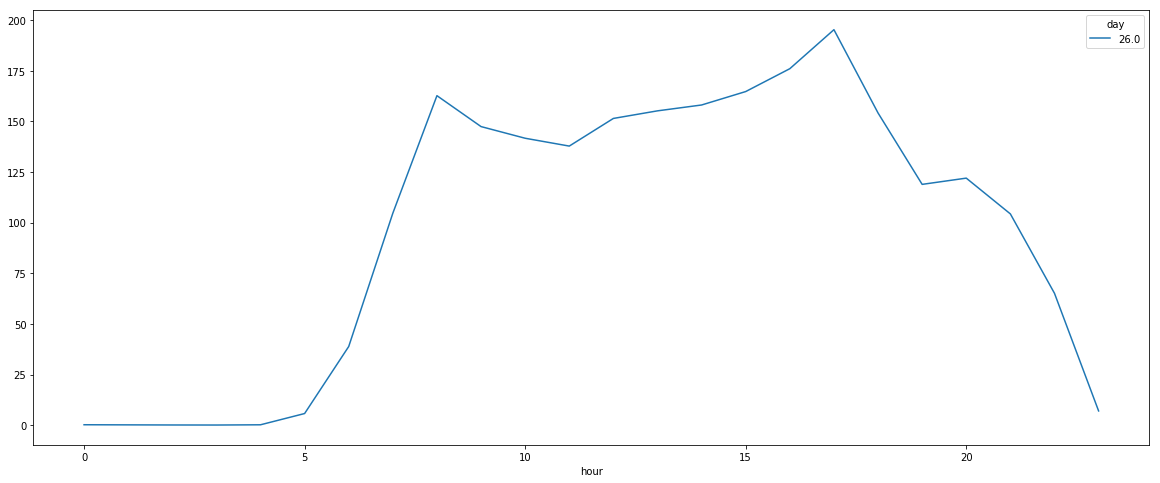

In [183]:
plt.rcParams['figure.figsize'] = (20.0, 8.0)
(data[(data.day.isin([26]))].groupby(['hour','day']).inNums.mean()).unstack().plot()
plt.show()

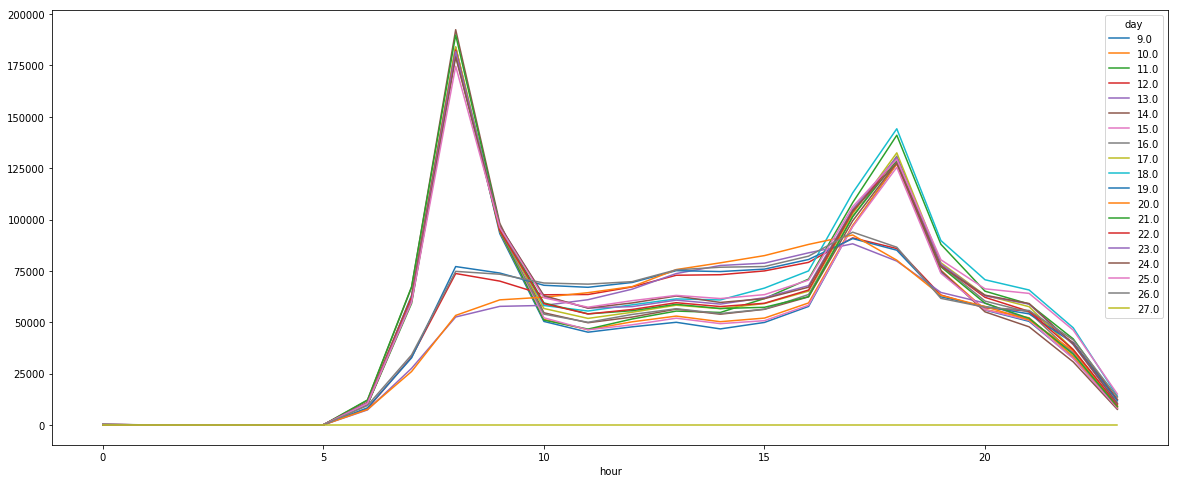

In [157]:
# 数据分析EDA
#stack简单说就是把columns转成index，unstack就是反过来
plt.rcParams['figure.figsize'] = (20.0, 8.0)
data.groupby(['hour', 'day']).outNums.sum().unstack().plot()
plt.show()

In [258]:
test['inNums'].sum()

1059598.2376760284

In [259]:
valid['inNums'].sum()

1123837.0

In [260]:
valid_res_inNums.sum()

1089476.107210519

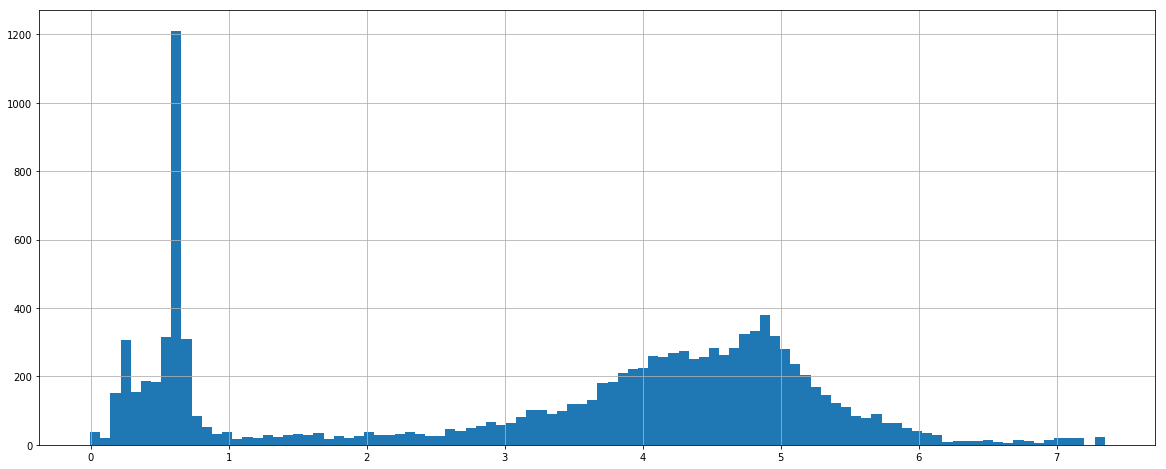

In [262]:
np.log1p(test['outNums']).hist(bins=100)

In [156]:
data.day.unique()

array([26.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.,
       21., 22., 23., 24., 25., 27.])

In [231]:
X_test.head()

,stationID,hour,minute,day,week,inNums_whm_max,inNums_whm_min,inNums_whm_mean,inNums_whm_median,outNums_whm_max,...,outNums_whm_median,inNums_wh_max,inNums_wh_min,inNums_wh_mean,inNums_wh_median,outNums_wh_max,outNums_wh_min,outNums_wh_mean,outNums_wh_median,inNums
0,0,0,0,29.0,2.0,0.0,0.0,0.0,0.0,3.0,...,1.5,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.227262
1,0,0,10,29.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.105688
2,0,0,20,29.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.101258
3,0,0,30,29.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.101184
4,0,0,40,29.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.25,0.0,0.088921


In [ ]:
def quantile_clip(group):
    group.plot()
    group[group < group.quantile(.05)] = group.quantile(.05)
    group[group > group.quantile(.95)] = group.quantile(.95)
    group.plot()
    plt.show()
    return group

data_eda.groupby(['stationID', 'day','hour','minute'])['inNums'].transform(quantile_clip)